In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import scipy
import time
import collections
import itertools
import librosa
import pickle

# Extract Features from Wave Files

In [25]:
#directory to training data and json file
train_dir='/Users/nadimkawwa/Desktop/Udacity/MLEND/Capstone/nsynth-train/audio/'
#directory to training data and json file
valid_dir='/Users/nadimkawwa/Desktop/Udacity/MLEND/Capstone/nsynth-valid/audio/'
#directory to training data and json file
test_dir='/Users/nadimkawwa/Desktop/Udacity/MLEND/Capstone/nsynth-test/audio/'

- Number of Zero Crossings
- max mean mfcc
- centroid mean
- centroid std
- centroid skewness
- max mean contrast
- rolloff mean
- rolloff std
- rolloff skewness
- zero crossing rate mean
- zero crossing rate std
- zero crossing rate skewness

In [5]:
#read the raw json files as given in the training set
df_train_raw = pd.read_json(path_or_buf='nsynth-train/examples.json', orient='index')

In [6]:
#Get a count of instruments in ascending order
n_class_train= df_train_raw['instrument_family'].value_counts(ascending=True)
n_class_train

9      5501
2      8773
10    10208
1     12675
7     13911
8     19474
3     32690
5     34201
6     34477
4     51821
0     65474
Name: instrument_family, dtype: int64

In [11]:
#Sample n files
df_train_sample=df_train_raw.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(5000)) #number of samples
#drop the synth_lead from the training dataset
df_train_sample= df_train_sample[df_train_sample['instrument_family']!=9]

In [13]:
df_train_sample.head()

,instrument,instrument_family,instrument_family_str,instrument_source,instrument_source_str,instrument_str,note,note_str,pitch,qualities,qualities_str,sample_rate,velocity
bass_synthetic_107-056-075,836,0,bass,2,synthetic,bass_synthetic_107,165861,bass_synthetic_107-056-075,56,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",[dark],16000,75
bass_synthetic_078-062-100,704,0,bass,2,synthetic,bass_synthetic_078,230104,bass_synthetic_078-062-100,62,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",[dark],16000,100
bass_synthetic_106-038-025,833,0,bass,2,synthetic,bass_synthetic_106,235667,bass_synthetic_106-038-025,38,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",[distortion],16000,25
bass_electronic_024-025-127,847,0,bass,1,electronic,bass_electronic_024,239754,bass_electronic_024-025-127,25,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",[distortion],16000,127
bass_synthetic_094-094-025,781,0,bass,2,synthetic,bass_synthetic_094,215683,bass_synthetic_094-094-025,94,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[],16000,25


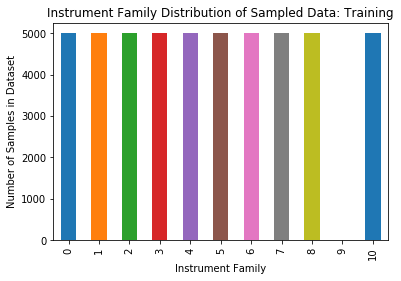

In [12]:
#Display instrument distrution
df_train_sample['instrument_family'].value_counts().reindex(np.arange(0,len(n_class_train), 1)).plot('bar')
plt.title("Instrument Family Distribution of Sampled Data: Training")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [18]:
#save the train file index as list
filenames_train = df_train_sample.index.tolist()

In [19]:
#save the list to a pickle file
with open('DataWrangling/filenames_train.pickle', 'wb') as f:
    pickle.dump(filenames_train, f)

In [20]:
#extract the filenames from the validation dataset
df_valid = pd.read_json(path_or_buf='nsynth-valid/examples.json', orient='index')

#save the train file index as list
filenames_valid = df_valid.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_valid.pickle', 'wb') as f:
    pickle.dump(filenames_valid, f)

In [21]:
#extract the filenames from the testing dataset
df_test = pd.read_json(path_or_buf='nsynth-test/examples.json', orient='index')

#save the train file index as list
filenames_test = df_test.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_test.pickle', 'wb') as f:
    pickle.dump(filenames_test, f)

In [28]:
def feature_extract(file):
    """
    Define function that takes in a file an returns features in an array
    """
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 1)
    
    #compute chroma energy
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 1)
    
    #compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis= 1)
    
    return [harmonic, mfcc, spectrogram, chroma, contrast]

In [103]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

The function above can take a lot of time for large datasets. It is advisisable to start out on small samples to get an estimate of running time.

## Testing Set

In [34]:
#create dictionary to store all test features
dict_test = {}
#loop over every file in the list
for file in filenames_test:
    #extract the features
    features = feature_extract(test_dir+ file + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_test[file] = features
    

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [38]:
#convert dict to dataframe
features_test = pd.DataFrame.from_dict(dict_test, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_test.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_068-049-025,1,"[-522.729417123482, 46.73630035531075, 34.3395...","[0.012438891109056644, 0.034936687412245135, 0...","[0.4305170426566291, 0.6118004906612967, 0.531...","[36.02463102901302, 29.189569835549623, 27.923..."
keyboard_electronic_001-021-127,0,"[-444.47229634410496, 193.9230119696005, 27.26...","[0.05536795855489122, 0.2012680490030723, 11.7...","[0.09875436329860442, 0.0874664479879011, 0.22...","[19.98616995783884, 19.848647976797974, 18.847..."
guitar_acoustic_010-066-100,0,"[-439.22322046511164, 59.58689689157284, 2.856...","[0.001401833520496928, 0.0033172451565636396, ...","[0.10204152262987645, 0.08729932552313621, 0.1...","[12.663278303311465, 34.85709984415947, 35.682..."
reed_acoustic_037-068-127,1,"[-373.1269985383674, 69.2447650312359, -39.842...","[0.0001462556663632036, 0.0004641471683807299,...","[0.035564534598694304, 0.01759427984279788, 0....","[19.59830865864867, 25.61093047441007, 30.8095..."
flute_acoustic_002-077-100,1,"[-364.77195353569994, 12.806340553776163, -43....","[4.9342375965810035e-05, 0.0001284664783243593...","[0.04172566939402538, 0.06470235645211833, 0.0...","[20.584888239106107, 10.5347221270656, 40.3229..."


In [45]:
#extract mfccs
mfcc_test = pd.DataFrame(features_test.mfcc.values.tolist(),index=features_test.index)
mfcc_test = mfcc_test.add_prefix('mfcc_')

#extract spectro
spectro_test = pd.DataFrame(features_test.spectro.values.tolist(),index=features_test.index)
spectro_test = spectro_test.add_prefix('spectro_')


#extract chroma
chroma_test = pd.DataFrame(features_test.chroma.values.tolist(),index=features_test.index)
chroma_test = chroma_test.add_prefix('chroma_')


#extract contrast
contrast_test = pd.DataFrame(features_test.contrast.values.tolist(),index=features_test.index)
contrast_test = chroma_test.add_prefix('contrast_')

#drop the old columns
features_test = features_test.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_test=pd.concat([features_test, mfcc_test, spectro_test, chroma_test, contrast_test],
                           axis=1, join='inner')
df_features_test.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_068-049-025,1,-522.729417,46.736300,34.339527,24.795487,17.434054,10.184167,4.615236,1.382405,-1.030897,...,0.531641,0.071409,0.006032,0.009253,0.014782,0.088950,0.102427,0.057437,0.010675,0.015779
keyboard_electronic_001-021-127,0,-444.472296,193.923012,27.263936,-3.658768,6.277335,8.114609,10.280759,6.098137,2.501384,...,0.221133,0.499389,0.431473,0.198991,0.186381,0.236050,0.402581,0.323163,0.029404,0.035821
guitar_acoustic_010-066-100,0,-439.223220,59.586897,2.856642,-12.013888,-12.567640,-11.456203,-12.535887,-20.437631,-19.245023,...,0.117914,0.085754,0.028640,0.436033,0.597927,0.473510,0.048822,0.025008,0.022679,0.004659
reed_acoustic_037-068-127,1,-373.126999,69.244765,-39.842655,-21.835653,-50.256348,-16.613256,-29.648702,-16.945005,-17.307318,...,0.046978,0.167250,0.068995,0.016955,0.015628,0.484009,0.655115,0.511854,0.013283,0.006798
flute_acoustic_002-077-100,1,-364.771954,12.806341,-43.040794,20.029764,-29.663241,-21.343329,-18.221209,-9.669494,7.875897,...,0.065065,0.046880,0.490144,0.651743,0.489015,0.026294,0.016009,0.024021,0.037190,0.025133


In [100]:
targets_test = []
for name in df_features_test.index.tolist():
    targets_test.append(instrument_code(name))

df_features_test['targets'] = targets_test

In [101]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_test.pickle', 'wb') as f:
    pickle.dump(df_features_test, f)

In [102]:
df_features_test.shape

(4096, 167)

## Traning Set

In [53]:
start_train = time.time()

#create dictionary to store all test features
dict_train = {}
#loop over every file in the list
for file in filenames_train:
    #extract the features
    features = feature_extract(train_dir+ file + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_train[file] = features

end_train=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_train), end_train - start_train))

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Time to extract 50000 files is 18657.50535917282 seconds


In [55]:
#convert dict to dataframe
features_train = pd.DataFrame.from_dict(dict_train, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_train.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_107-056-075,1,"[-464.7390337229504, 73.49795529273366, 63.116...","[0.07956717399727602, 0.042379425353967125, 0....","[0.08718473999606306, 0.05595632682486415, 0.1...","[12.864133319312929, 21.09899419995787, 44.044..."
bass_synthetic_078-062-100,0,"[-363.0354277152968, 114.58564229798003, -0.26...","[4.929554319984393, 0.7158158408795735, 0.1754...","[0.16043790484219994, 0.43622227153883153, 0.5...","[18.686871436233364, 24.120583028642063, 24.02..."
bass_synthetic_106-038-025,0,"[-394.2287423304462, 198.1855410334663, 84.835...","[0.2016194865911648, 2.6732475511814004, 27.30...","[0.0846150391783723, 0.40554557664749935, 0.61...","[22.39865496502368, 23.107795488100603, 27.964..."
bass_electronic_024-025-127,1,"[-408.4331026236968, 95.85717373307556, 71.383...","[19.145341303917633, 640.138045415899, 3243.30...","[0.4875271791562823, 0.5313034341438725, 0.400...","[26.37182399103798, 16.20915738848254, 18.2489..."
bass_synthetic_094-094-025,0,"[-532.5485262179037, -10.137038642522, -22.214...","[2.7921139611916892e-05, 9.825728974478066e-06...","[0.06792684971082044, 0.04530926915802141, 0.0...","[18.076782748956695, 16.103365266566488, 20.03..."


In [56]:
#extract mfccs
mfcc_train = pd.DataFrame(features_train.mfcc.values.tolist(),
                          index=features_train.index)
mfcc_train = mfcc_train.add_prefix('mfcc_')

#extract spectro
spectro_train = pd.DataFrame(features_train.spectro.values.tolist(),
                             index=features_train.index)
spectro_train = spectro_train.add_prefix('spectro_')


#extract chroma
chroma_train = pd.DataFrame(features_train.chroma.values.tolist(),
                            index=features_train.index)
chroma_train = chroma_train.add_prefix('chroma_')


#extract contrast
contrast_train = pd.DataFrame(features_train.contrast.values.tolist(),
                              index=features_train.index)
contrast_train = chroma_train.add_prefix('contrast_')

#drop the old columns
features_train = features_train.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_train=pd.concat([features_train, mfcc_train, spectro_train, chroma_train, contrast_train],
                           axis=1, join='inner')
df_features_train.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_107-056-075,1,-464.739034,73.497955,63.116447,48.108825,31.025012,14.320454,0.017443,-10.511474,-16.714126,...,0.118063,0.056975,0.013938,0.028138,0.050709,0.487929,0.614493,0.435582,0.032069,0.004083
bass_synthetic_078-062-100,0,-363.035428,114.585642,-0.264277,0.179338,0.178242,-2.319644,0.886480,-1.249431,0.269356,...,0.531429,0.500799,0.093680,0.025879,0.022395,0.036193,0.033505,0.110375,0.129588,0.038207
bass_synthetic_106-038-025,0,-394.228742,198.185541,84.835110,-6.086613,-33.108344,-19.092043,-4.297194,-1.915769,-2.359507,...,0.617979,0.383752,0.056206,0.085008,0.174667,0.101176,0.160597,0.251001,0.146896,0.048511
bass_electronic_024-025-127,1,-408.433103,95.857174,71.383336,56.379193,41.276001,28.982601,22.165213,17.668771,14.229128,...,0.400761,0.102857,0.080990,0.056740,0.041706,0.207965,0.320208,0.147046,0.057054,0.058128
bass_synthetic_094-094-025,0,-532.548526,-10.137039,-22.214534,26.531165,1.674073,7.063939,4.614965,-21.844682,17.727311,...,0.048409,0.037805,0.037097,0.018134,0.014596,0.019296,0.015597,0.479857,0.651988,0.494912


In [84]:
targets_train = []
for name in df_features_train.index.tolist():
    targets_train.append(instrument_code(name))


In [91]:
df_features_train['targets'] = targets_train

In [92]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_train.pickle', 'wb') as f:
    pickle.dump(df_features_train, f)

In [93]:
df_features_train.shape

(50000, 167)

## Validation Set

In [59]:
start_valid = time.time()

#create dictionary to store all test features
dict_valid = {}
#loop over every file in the list
for file in filenames_valid:
    #extract the features
    features = feature_extract(valid_dir+ file + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_valid[file] = features

end_valid=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_valid), end_valid - start_valid))

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Time to extract 12678 files is 4654.57950592041 seconds


In [60]:
#convert dict to dataframe
features_valid = pd.DataFrame.from_dict(dict_valid, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_valid.head()

,harmonic,mfcc,spectro,chroma,contrast
keyboard_acoustic_004-060-025,1,"[-475.0599666026437, 57.9049653643272, 45.3977...","[1.2372668245985774, 2.7320972951131233, 1.056...","[0.5894005568313697, 0.4270304137419671, 0.040...","[20.76343497665678, 29.197236348836064, 28.282..."
bass_synthetic_033-050-100,1,"[-423.1171470261246, 69.20058180675211, 45.416...","[2.3285040954053486, 0.09685664909898768, 0.08...","[0.14050136435242797, 0.390144416711426, 0.566...","[30.68382886841031, 29.58135354073383, 32.8445..."
bass_synthetic_009-052-050,0,"[-149.23472374569982, 53.307137543838955, -50....","[0.8283798212765306, 0.03547111069334372, 0.03...","[0.187415879551152, 0.001908716635199173, 0.00...","[32.311582061214835, 30.70394878499703, 34.818..."
keyboard_electronic_003-064-127,0,"[-499.9362295075221, 47.04751446249375, 13.790...","[0.000794709799624487, 0.004492601411796467, 0...","[0.00836718769901377, 0.0008663765722982901, 0...","[17.210256931450676, 29.901833163963854, 30.24..."
bass_synthetic_034-030-050,1,"[-411.42047109116305, 67.55020196935848, 39.09...","[0.994075733465726, 5.060984523746281, 85.6424...","[0.1963821939125205, 0.39260497312668574, 0.17...","[28.277958740735333, 20.29757882984112, 19.941..."


In [61]:
#extract mfccs
mfcc_valid = pd.DataFrame(features_valid.mfcc.values.tolist(),
                          index=features_valid.index)
mfcc_valid = mfcc_valid.add_prefix('mfcc_')

#extract spectro
spectro_valid = pd.DataFrame(features_valid.spectro.values.tolist(),
                             index=features_valid.index)
spectro_valid = spectro_valid.add_prefix('spectro_')


#extract chroma
chroma_valid = pd.DataFrame(features_valid.chroma.values.tolist(),
                            index=features_valid.index)
chroma_valid = chroma_valid.add_prefix('chroma_')


#extract contrast
contrast_valid = pd.DataFrame(features_valid.contrast.values.tolist(),
                              index=features_valid.index)
contrast_valid = chroma_valid.add_prefix('contrast_')

#drop the old columns
features_valid = features_valid.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_valid=pd.concat([features_valid, mfcc_valid, spectro_valid, chroma_valid, contrast_valid],
                           axis=1, join='inner')
df_features_valid.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
keyboard_acoustic_004-060-025,1,-475.059967,57.904965,45.397786,33.654257,23.840651,16.517649,11.215566,6.625139,2.417870,...,0.040974,0.073346,0.131672,0.167997,0.161846,0.113347,0.113519,0.079041,0.068088,0.413653
bass_synthetic_033-050-100,1,-423.117147,69.200582,45.416585,22.664521,8.433683,1.113607,-2.524592,-3.295073,-2.176944,...,0.566293,0.455566,0.094304,0.046154,0.000859,0.078811,0.052517,0.089218,0.088820,0.051163
bass_synthetic_009-052-050,0,-149.234724,53.307138,-50.052933,72.835626,-48.004279,37.524718,-38.533355,19.412516,-23.413315,...,0.003888,0.469621,0.677325,0.452823,0.001909,0.000000,0.000000,0.000000,0.134581,0.247741
keyboard_electronic_003-064-127,0,-499.936230,47.047514,13.790718,8.749692,3.253123,-1.371571,-5.380596,-7.059535,-8.347108,...,0.004917,0.405893,0.545605,0.458490,0.088808,0.154312,0.144893,0.064207,0.038475,0.023381
bass_synthetic_034-030-050,1,-411.420471,67.550202,39.091344,55.981923,24.597699,26.598870,12.040562,12.276508,6.266154,...,0.179437,0.076811,0.076412,0.359199,0.504694,0.410889,0.082257,0.003461,0.082358,0.065493


In [97]:
targets_valid = []
for name in df_features_valid.index.tolist():
    targets_valid.append(instrument_code(name))

df_features_valid['targets'] = targets_valid

In [98]:
df_features_valid.shape

(12678, 167)

In [99]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_valid.pickle', 'wb') as f:
    pickle.dump(df_features_valid, f)

# Clean JSON Files

In [135]:
#extract qualities
train_qual = pd.DataFrame(df_train_sample.qualities.values.tolist(), index= df_train_sample.index)


#concatenate
json_train=pd.concat([df_train_sample, train_qual],
                           axis=1, join='inner')

json_train= json_train.drop(labels=['qualities'], axis=1)
json_train.head()

,instrument,instrument_family,instrument_family_str,instrument_source,instrument_source_str,instrument_str,note,note_str,pitch,qualities_str,...,0,1,2,3,4,5,6,7,8,9
bass_synthetic_107-056-075,836,0,bass,2,synthetic,bass_synthetic_107,165861,bass_synthetic_107-056-075,56,[dark],...,0,1,0,0,0,0,0,0,0,0
bass_synthetic_078-062-100,704,0,bass,2,synthetic,bass_synthetic_078,230104,bass_synthetic_078-062-100,62,[dark],...,0,1,0,0,0,0,0,0,0,0
bass_synthetic_106-038-025,833,0,bass,2,synthetic,bass_synthetic_106,235667,bass_synthetic_106-038-025,38,[distortion],...,0,0,1,0,0,0,0,0,0,0
bass_electronic_024-025-127,847,0,bass,1,electronic,bass_electronic_024,239754,bass_electronic_024-025-127,25,[distortion],...,0,0,1,0,0,0,0,0,0,0
bass_synthetic_094-094-025,781,0,bass,2,synthetic,bass_synthetic_094,215683,bass_synthetic_094-094-025,94,[],...,0,0,0,0,0,0,0,0,0,0


In [136]:
#save the dataframe to a pickle file
with open('DataWrangling/json_train.pickle', 'wb') as f:
    pickle.dump(json_train, f)

In [138]:
#extract qualities
test_qual = pd.DataFrame(df_test.qualities.values.tolist(), index= df_test.index)


#concatenate
json_test=pd.concat([df_test, test_qual],
                           axis=1, join='inner')

json_test= json_test.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_test.pickle', 'wb') as f:
    pickle.dump(json_test, f)

In [139]:
#extract qualities
valid_qual = pd.DataFrame(df_valid.qualities.values.tolist(), index= df_valid.index)


#concatenate
json_valid=pd.concat([df_valid, valid_qual],
                           axis=1, join='inner')

json_valid= json_valid.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_valid.pickle', 'wb') as f:
    pickle.dump(json_valid, f)